In [1]:
%%bash
#pip install https://github.com/hadim/anamic/archive/f35713231804e0a35fec3c92f894a36ec8009453.zip

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import json

import anamic

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
from skimage.exposure import rescale_intensity

import tifffile
import read_roi
import tqdm

pixel_size = 107  # nm
dt = 40  # ms

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


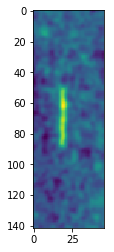

In [49]:
# Open the image and its starting points for fitting
data_dir = Path('D:/Claire/MTs with Drugs/2020-02-28 IRM MTs with DZA and Taxol/ch2 100nM DZA 10uM tubulin 2pt5 spf journal1')
fname = data_dir / "2020-02-28 ch2 100nM DZA 10uM tubulin 10ms SINGLE MT.tif"

# Open the image
stack = tifffile.imread(str(fname))

# Load ROIs
rois = read_roi.read_roi_zip(fname.with_suffix('.zip'))

roi = rois['0500-0079-0018']

tip_start = np.array([roi['y1'], roi['x1']])
tip_end = np.array([roi['y2'], roi['x2']])

# Average every n frames to increase SNR.
n = 2
stack = np.array([stack[i::n] for i in range(n)]).sum(axis=0) / n
stack = rescale_intensity(stack, out_range='uint16').astype('uint16')
tifffile.imsave(fname.with_suffix('.AVERAGED.tif'), stack)

new_dt = dt * 8

image = stack[100]
plt.imshow(image)

## Single Image Fit (to find optimal parameters)

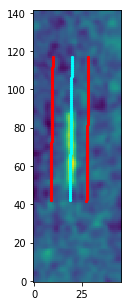

In [50]:
args = {}

args['get_thick_line_args'] = {}
args['get_thick_line_args']['length_spacing'] = 1  # pixel
args['get_thick_line_args']['line_thickness'] = 2000 / pixel_size  # pixel
args['get_thick_line_args']['width_spacing'] = 1  # pixel

lines = anamic.fitter.get_thick_line(tip_start, tip_end, **args['get_thick_line_args'])

# Check the new points.
fig, ax = plt.subplots(figsize=(5, 5))

ax.imshow(image, interpolation='none', origin=[0, 0], cmap='viridis')
ax.set_aspect('equal')

ax.scatter(lines[1, 0], lines[0, 0], color='red', s=20, marker=".")
ax.scatter(lines[1, -1], lines[0, -1], color='red', s=20, marker=".")

middle_index = int(lines.shape[1] / 2)
ax.scatter(lines[1, middle_index], lines[0, middle_index], color='cyan', s=20, marker=".")

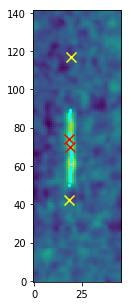

In [54]:
args['perpendicular_line_fit_args'] = {}
args['perpendicular_line_fit_args']['length_spacing'] = 0.1  # pixel
args['perpendicular_line_fit_args']['fit_threshold'] = 0.05
args['perpendicular_line_fit_args']['continuous_discard'] = False

fitted_line = anamic.fitter.perpendicular_line_fit(lines, image,
                                                   **args['perpendicular_line_fit_args'])

# Now we fit the best line from those points
a, b = np.polyfit(fitted_line[:, 1], fitted_line[:, 0], deg=1)
new_point1 = np.array([a * fitted_line[0, 1] + b, fitted_line[0, 1]])
new_point2 = np.array([a * fitted_line[-1, 1] + b, fitted_line[-1, 1]])

# This the new line defining the microtubule
new_line = np.array([new_point1, new_point2])

# Check the fitted points
fig, ax = plt.subplots(figsize=(5, 5))

ax.imshow(image, interpolation='none', origin=[0, 0], cmap='viridis')
ax.set_aspect('equal')

initial_line = np.array([tip_start, tip_end])

ax.scatter(fitted_line[:, 1], fitted_line[:, 0], color='cyan', s=20, marker=".")
ax.scatter(new_line[:, 1], new_line[:, 0], color='red', s=100, marker="x")
ax.scatter(initial_line[:, 1], initial_line[:, 0], color='yellow', s=100, marker="x")

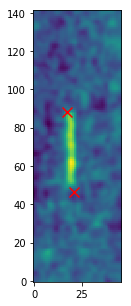

In [55]:
# Now we fit the microtubule using a line profile with a defined thickness.

args['offset_start'] = 3000 / pixel_size  # pixel
args['offset_end'] = 1500 / pixel_size  # pixel

# Calculate the vector of the line and its norm
vec = new_point2 - new_point1

# Get the coordinates of the points we'll use
# to for line fitting.
start_point = anamic.geometry.get_point_from_vector(-vec, new_point2, args['offset_start'])
end_point = anamic.geometry.get_point_from_vector(vec, new_point2, args['offset_end'])
line_fit_tips = np.array([start_point, end_point])

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(image, interpolation='none', origin=[0, 0], cmap='viridis')
ax.set_aspect('equal')
ax.scatter(line_fit_tips[:, 1], line_fit_tips[:, 0], color='red', s=100, marker="x")

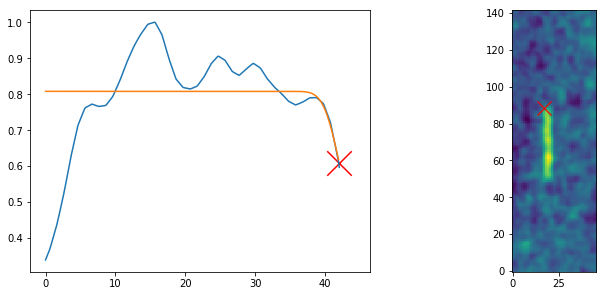

In [56]:
args['tip_fit_args'] = {}
args['tip_fit_args']['length_spacing'] = 0.1  # pixel
args['tip_fit_args']['line_thickness'] = 200 / pixel_size  # pixel
args['tip_fit_args']['width_spacing'] = 0.1  # pixel

x_profile, y_profile, fit_result, fit_func = anamic.fitter.tip_line_fit(line_fit_tips[0],
                                                                        line_fit_tips[1],
                                                                        image,
                                                                        **args['tip_fit_args'])
fit_values = fit_result.values

mu = fit_values['mu']
tip_position = anamic.geometry.get_point_from_vector(vec, line_fit_tips[0], mu)

x = np.arange(x_profile[0], x_profile[-1], 0.1)
y_fitted = fit_func(x, **fit_values)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), constrained_layout=True)
ax1.plot(x_profile, y_profile, label='data')
ax1.plot(x, y_fitted, label='fit')
ax1.scatter(mu, fit_func(mu, **fit_values), color='red', s=600, marker='x')

ax2.imshow(image, interpolation='none', origin=[0, 0], cmap='viridis')
ax2.set_aspect('equal')
ax2.scatter(tip_position[1], tip_position[0], color='red', s=200, marker="x", alpha=0.8)

## Batch Fit (all timepoints)

In [ ]:
# IMPORTANT: take into account the number of averaged frames.
frame_start = 28  # Fun starts at 28.
frame_end = 73  # Fun ends at 73.

data = []
for i, frame in enumerate(tqdm.trange(frame_start, frame_end)):
    
    image = stack[frame]
    
    args = {}

    args['get_thick_line_args'] = {}
    args['get_thick_line_args']['length_spacing'] = 1  # pixel
    args['get_thick_line_args']['line_thickness'] = 2000 / pixel_size  # pixel
    args['get_thick_line_args']['width_spacing'] = 1  # pixel

    lines = anamic.fitter.get_thick_line(tip_start, tip_end, **args['get_thick_line_args'])

    args['perpendicular_line_fit_args'] = {}
    args['perpendicular_line_fit_args']['length_spacing'] = 0.1  # pixel
    args['perpendicular_line_fit_args']['fit_threshold'] = 0.08
    args['perpendicular_line_fit_args']['continuous_discard'] = False

    fitted_line = anamic.fitter.perpendicular_line_fit(lines, image,
                                                       **args['perpendicular_line_fit_args'])

    # Now we fit the best line from those points
    a, b = np.polyfit(fitted_line[:, 1], fitted_line[:, 0], deg=1)
    new_point1 = np.array([a * fitted_line[0, 1] + b, fitted_line[0, 1]])
    new_point2 = np.array([a * fitted_line[-1, 1] + b, fitted_line[-1, 1]])

    # This the new line defining the microtubule
    new_line = np.array([new_point1, new_point2])

    # Now we fit the microtubule using a line profile with a defined thickness.

    args['offset_start'] = 3000 / pixel_size  # pixel
    args['offset_end'] = 1500 / pixel_size  # pixel

    # Calculate the vector of the line and its norm
    vec = new_point2 - new_point1

    # Get the coordinates of the points we'll use
    # to for line fitting.
    start_point = anamic.geometry.get_point_from_vector(-vec, new_point2, args['offset_start'])
    end_point = anamic.geometry.get_point_from_vector(vec, new_point2, args['offset_end'])
    line_fit_tips = np.array([start_point, end_point])
    
    args['tip_fit_args'] = {}
    args['tip_fit_args']['length_spacing'] = 0.1  # pixel
    args['tip_fit_args']['line_thickness'] = 200 / pixel_size  # pixel
    args['tip_fit_args']['width_spacing'] = 0.1  # pixel

    x_profile, y_profile, fit_result, fit_func = anamic.fitter.tip_line_fit(line_fit_tips[0],
                                                                            line_fit_tips[1],
                                                                            image,
                                                                            **args['tip_fit_args'])
    fit_values = fit_result.values

    mu = fit_values['mu']
    tip_position = anamic.geometry.get_point_from_vector(vec, line_fit_tips[0], mu)
    
    datum = {}
    datum['x'] = tip_position[0]
    datum['y'] = tip_position[1]
    datum['index'] = i
    datum['frame'] = frame
    datum['time'] = i * new_dt
    data.append(datum)
    
data = pd.DataFrame(data)
data.to_csv(fname.with_suffix('.csv'), index=False)

 42%|██████████████████████████████████▌                                               | 19/45 [00:34<00:43,  1.66s/it]

In [35]:
# Read the data
data = pd.read_csv(fname.with_suffix('.csv'))
data = data.set_index('frame')
data

,index,time,x,y
frame,,,,
28,0,0,57.744690,21.148283
29,1,320,79.498712,18.594987
30,2,640,73.852891,18.950172
31,3,960,69.362893,15.375676
32,4,1280,79.973454,18.475304
33,5,1600,79.477167,17.964463
34,6,1920,75.498482,18.397415
35,7,2240,59.579086,19.578368
36,8,2560,77.028573,18.425631


Text(0.75, 0.9, '14080.00 s')

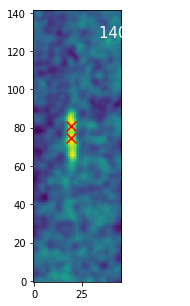

In [41]:
# Visualize frames one by one
frame = 72

fig, ax = plt.subplots(figsize=(5, 5))

ax.imshow(stack[frame], interpolation='none', origin=[0, 0], cmap='viridis')
ax.set_aspect('equal')
ax.scatter(tip_start[1], tip_start[0], color='red', s=100, marker="x")

x, y = data.loc[frame, ['y', 'x']]
ax.scatter(x, y, color='red', s=100, marker="x")

ax.text(0.75, 0.9, f"{data.loc[frame, 'time']:2.2f} s",
        transform=ax.transAxes, color='#ffffff', fontsize=15)

TypeError: argument of type 'WindowsPath' is not iterable

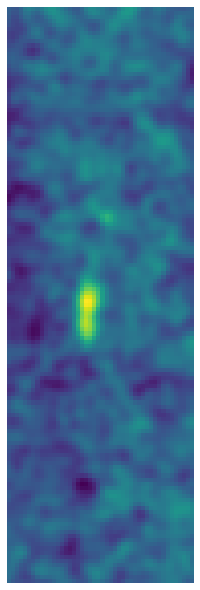

In [42]:
# Make a movie

movie_fps = 5  # frame/sec
image_size = 8
movie_dpi = 100

FFMpegWriter = manimation.writers['ffmpeg']
writer = FFMpegWriter(fps=movie_fps)

fig, ax = plt.subplots(figsize=(image_size, image_size))
mpl_im = ax.imshow(stack[frame_start], aspect='equal', interpolation='none')
mpl_tip = ax.scatter([], [], color='red', marker='x')
mpl_text = ax.text(0.75, 0.9, "", transform=ax.transAxes, color='#ffffff', fontsize=34)

ax.grid(False); ax.set_xticks([]); ax.set_yticks([]); ax.set_axis_off()
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

with writer.saving(fig, fname.with_suffix('.mp4'), movie_dpi):
    for frame in range(frame_start, frame_end):
        mpl_im.set_data(stack[frame])
        mpl_tip.set_offsets(data.loc[frame, ['y', 'x']].values)
        mpl_text.set_text(f"{data.loc[frame, 'time_s']:2.2f} s")
        writer.grab_frame()

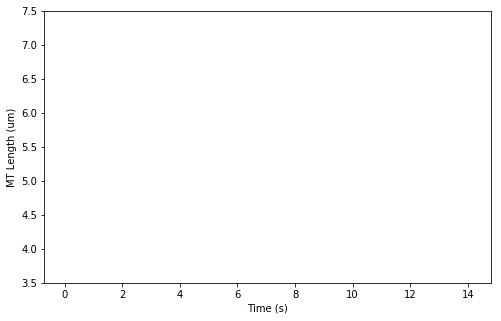

In [43]:
# Make a nice length versus time plot
# Length is calculated from a fixed reference located on the MT.

data['length_pixel'] = np.sqrt(((data.loc[:, ['x', 'y']] - tip_start) ** 2).sum(axis=1))
data['length_um'] = data['length_pixel'] * pixel_size / 1000
data['time_s'] = data['time'] / 1000

if data.index.name == 'frame':
    data = data.reset_index()
data.to_csv(fname.with_suffix('.csv'), index=False)
if data.index.name != 'frame':
    data = data.set_index('frame')

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(data['time_s'], data['length_um'])

ax.set_ylim(3.5, 7.5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('MT Length (um)')
fig.savefig(fname.with_suffix('.PLOT.png'))